# Regressão Logística I
## Tarefa II

Vamos trabalhar com a mesma base do exercício anterior, mas vamos aprofundar um pouco mais a nossa regressão.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import statsmodels.formula.api as smf

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'

df = pd.read_csv(url, 
                 names=['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                        'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'])
df['flag_doente'] = (df['num']!=0).astype('int64')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0


A descrição das variáveis está recortada abaixo:
- age: idade do paciente em anos
- sex: sexo (1 = male; 0 = female)  
- cp: tipo de dor no peito
  - 1: angina típica
  - 2: angina atípica
  - 3: dor não-angina
  - 4: assintomático
- trestbps: pressão sanguínea em repouso (em mm Hg na admissão ao hospital
- chol: colesterol sérico em mg/dl
- fbs: (açúcar no sangue em jejum > 120 mg/dl) (1 = True; 0 = False)
- restecg: resultados eletrocardiográficos em repouso
  - 0: normal
  - 1: tendo anormalidade da onda ST-T (Inversões de onda T e / ou ST com elevação ou depressão de > 0.05 mV)
  - 2: mostrando hipertrofia ventricular esquerda provável ou definitiva pelos critérios de Estes
- thalach: frequência cardíaca máxima alcançada
- exang: angina induzida por exercício(1 = sim; 0 = não)
- oldpeak = Depressão de ST induzida por exercício em relação ao repouso
- slope: Depressão de ST induzida por exercício em relação ao repouso
  - 1: inclinação ascendente
  - 2: estável
  - 3: inclinação descendente
- ca: número de vasos principais (0-3) coloridos por fluorosopia
- thal: 3 = normal; 6 = defeito corrigido; 7 = defeito reversível
- num: diagnóstico de doença cardíaga (status de doença angiográfica)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          303 non-null    float64
 1   sex          303 non-null    float64
 2   cp           303 non-null    float64
 3   trestbps     303 non-null    float64
 4   chol         303 non-null    float64
 5   fbs          303 non-null    float64
 6   restecg      303 non-null    float64
 7   thalach      303 non-null    float64
 8   exang        303 non-null    float64
 9   oldpeak      303 non-null    float64
 10  slope        303 non-null    float64
 11  ca           303 non-null    object 
 12  thal         303 non-null    object 
 13  num          303 non-null    int64  
 14  flag_doente  303 non-null    int64  
dtypes: float64(11), int64(2), object(2)
memory usage: 35.6+ KB


1. Considere o script que monta a análise bivariada que você fez na tarefa anterior. Transforme esse script em uma função, que deve:
- Ter como parâmetros de entrada:
    - Um *dataframe* contendo os dados a serem avaliados
    - Um *string* contendo o nome da variável resposta
    - Um *string* contendo o nome da variável explicativa
- E deve retornar um *dataframe* com os dados da bivariada. 
**Monte** a mesma bivariada pelo menos três variáveis qualitativas do *data-frame*. Qual delas parece discriminar mais o risco?

In [4]:
def bivariada_logistica(df, y, x):
    
    tab = pd.crosstab(df[x], df[y], margins=True)

    # Total
    tab["total"] = tab["All"]

    # Chance / risco
    tab["chance"] = tab[1] / tab["total"]

    # Odds = p/(1-p) 
    tab["odds"] = tab[1] / tab[0]

    # Odds ratio usando a linha "All" como referência
    tab["odds_ratio"] = tab["odds"] / tab.loc["All", "odds"]

    # Logito e WOE
    tab["logito"] = np.log(tab["odds"])
    tab["woe"] = np.log(tab["odds_ratio"])

    return tab

2. Monte uma função semelhante para categorizar variáveis quantitativas contínuas (com muitas categorias) como ```age```.  
    Além dos mesmos parâmetros da função anterior, defina mais um parâmetro como número de categorias que você deseja quebrar. Defina um valor '*default*' de 5 grupos para este parâmetro.  

In [5]:
def bivariada_logistica_continua(df, y, x, q=5):
    
    x_cat = pd.qcut(df[x], q=q, duplicates="drop")
    
    tab = bivariada_logistica(
        df.assign(**{f"{x}_cat": x_cat}),
        y,
        f"{x}_cat"
    )
    
    return tab


3. Construa um modelo de regressão logística com as variáveis qualitativas: ```sex + cp +  trestbps``` e com a variável quantitativa ```age```.

**Interprete os parâmetros.**

In [6]:
df["trestbps_cat"] = pd.qcut(df["trestbps"], q=5, duplicates="drop")


In [7]:

modelo = smf.logit(
    "flag_doente ~ C(sex) + C(cp) + C(trestbps_cat) + age",
    data=df
).fit()

print(modelo.summary())


Optimization terminated successfully.
         Current function value: 0.475760
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      293
Method:                           MLE   Df Model:                            9
Date:                Tue, 20 Jan 2026   Pseudo R-squ.:                  0.3102
Time:                        15:51:06   Log-Likelihood:                -144.16
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 1.385e-23
                                                                coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------
Intercept     

O modelo mostra que homens, pessoas com dor no peito mais grave e mais idade têm maior chance de apresentar doença cardíaca. O tipo de dor no peito é o fator que mais diferencia quem tem e quem não tem a doença.

A pressão arterial só faz diferença clara nos valores mais altos. No geral, o modelo faz sentido e os resultados estão de acordo com o esperado

4. Avalie o seu modelo quanto a **calibragem**:
- Calcule a probabilidade de evento predita segundo o seu modelo
- Categorize essa probabilidade em G=5 grupos
- Calcule a probabilidade de evento predita média por grupo
- Calcule a taxa de eventos (média da variável indicadora de eventos) por grupo
- Compare graficamente o valor eperado versus observado para a taxa de maus por grupo

In [8]:
df["p_pred"] = modelo.predict(df)
df[["flag_doente", "p_pred"]].head()


,flag_doente,p_pred
0,0,0.530640
1,1,0.943220
2,1,0.875677
3,0,0.151773
4,0,0.032231


In [9]:
df["grupo_prob"] = pd.qcut(df["p_pred"], q=5)

calibragem = df.groupby("grupo_prob").agg(
    prob_pred_media=("p_pred", "mean"),
    taxa_evento_obs=("flag_doente", "mean")
).reset_index()

calibragem


C:\Users\felip\AppData\Local\Temp\ipykernel_23620\2362162195.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calibragem = df.groupby("grupo_prob").agg(


,grupo_prob,prob_pred_media,taxa_evento_obs
0,"(0.0127, 0.126]",0.067197,0.065574
1,"(0.126, 0.308]",0.210336,0.183333
2,"(0.308, 0.6]",0.437707,0.491803
3,"(0.6, 0.819]",0.701049,0.683333
4,"(0.819, 0.962]",0.877340,0.868852


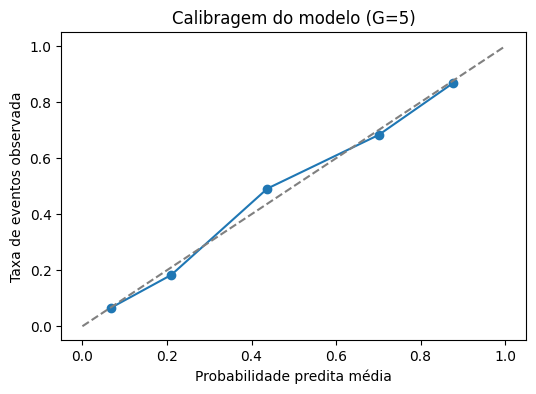

In [10]:

plt.figure(figsize=(6,4))

plt.plot(
    calibragem["prob_pred_media"],
    calibragem["taxa_evento_obs"],
    marker="o"
)

# linha de calibragem perfeita
plt.plot([0,1], [0,1], linestyle="--", color="gray")

plt.xlabel("Probabilidade predita média")
plt.ylabel("Taxa de eventos observada")
plt.title("Calibragem do modelo (G=5)")

plt.show()


5. Avalie o seu modelo quanto a discriminação calculando acurácia, GINI e KS.

In [12]:
from sklearn.metrics import accuracy_score

df["y_pred"] = (df["p_pred"] >= 0.5).astype(int)

acc = accuracy_score(df["flag_doente"], df["y_pred"])
acc


0.7722772277227723

In [13]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(df["flag_doente"], df["p_pred"])
gini = 2 * auc - 1

auc, gini


(0.852386383576066, 0.704772767152132)

In [15]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(df["flag_doente"], df["p_pred"])
ks = np.max(tpr - fpr)

ks


np.float64(0.5739164765748377)

O modelo apresenta boa discriminação, com acurácia em torno de 77%, GINI elevado e KS próximo de 0,57, indicando que consegue separar bem indivíduos com maior e menor risco de doença cardíaca.

6. tente melhorar o modelo obtido, por exemplo inserindo ou removendo variáveis.  
    Avalie as características do seu modelo (calibragem e acurácia).

In [16]:
modelo_melhor = smf.logit(
    "flag_doente ~ C(sex) + C(cp) + C(trestbps_cat) + age + thalach + oldpeak + C(exang)",
    data=df
).fit()

print(modelo_melhor.summary())


Optimization terminated successfully.
         Current function value: 0.406499
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      290
Method:                           MLE   Df Model:                           12
Date:                Tue, 20 Jan 2026   Pseudo R-squ.:                  0.4106
Time:                        16:03:51   Log-Likelihood:                -123.17
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 2.201e-30
                                                                coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------
Intercept     

In [17]:
df["p_pred_melhor"] = modelo_melhor.predict(df)
df["y_pred_melhor"] = (df["p_pred_melhor"] >= 0.5).astype(int)

from sklearn.metrics import accuracy_score

acc_melhor = accuracy_score(df["flag_doente"], df["y_pred_melhor"])
acc_melhor


0.8250825082508251

In [18]:
df["grupo_prob_melhor"] = pd.qcut(df["p_pred_melhor"], q=5)

calibragem_melhor = df.groupby("grupo_prob_melhor").agg(
    prob_pred_media=("p_pred_melhor", "mean"),
    taxa_evento_obs=("flag_doente", "mean")
).reset_index()

calibragem_melhor


C:\Users\felip\AppData\Local\Temp\ipykernel_23620\3251438980.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calibragem_melhor = df.groupby("grupo_prob_melhor").agg(


,grupo_prob_melhor,prob_pred_media,taxa_evento_obs
0,"(0.00714, 0.0967]",0.047913,0.049180
1,"(0.0967, 0.262]",0.168236,0.200000
2,"(0.262, 0.555]",0.399186,0.344262
3,"(0.555, 0.883]",0.725052,0.766667
4,"(0.883, 0.996]",0.952946,0.934426


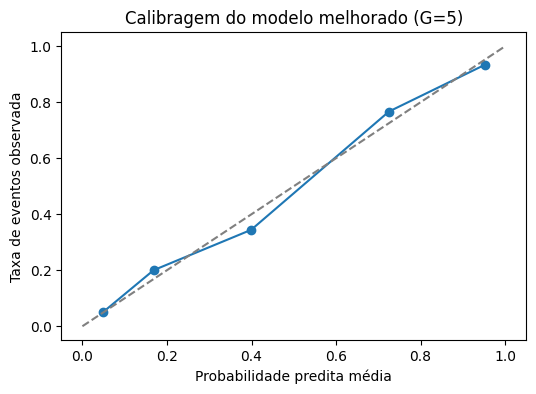

In [19]:

plt.figure(figsize=(6,4))
plt.plot(
    calibragem_melhor["prob_pred_media"],
    calibragem_melhor["taxa_evento_obs"],
    marker="o"
)
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("Probabilidade predita média")
plt.ylabel("Taxa de eventos observada")
plt.title("Calibragem do modelo melhorado (G=5)")
plt.show()


A inclusão de novas variáveis melhorou o desempenho do modelo, aumentando a acurácia e mantendo boa calibragem.